In [1]:
import pandas as pd
import requests
import os
import re

# Kinases dataset

In [2]:
# All kinases dataset
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower().str.replace(" ", "_")
# Select human proteins
human_kinases = kinases[['uniprot', 'organism']].drop_duplicates()
human_kinases = human_kinases[human_kinases.organism == 'H. sapiens']
human_kinases

,uniprot,organism
11,A8KAM8,H. sapiens
15,O14757,H. sapiens
16,O15146,H. sapiens
19,O43318,H. sapiens
22,O75582,H. sapiens
...,...,...
271,Q9H2X6,H. sapiens
272,Q9H4A3,H. sapiens
288,Q9UIK4,H. sapiens
291,Q9Y243,H. sapiens


In [3]:
uniprot_ids = list(human_kinases.uniprot.unique())
len(uniprot_ids)

87

### Bring also ortholog kinases

In [4]:
orthologs = pd.read_csv('../datasets/orthologs_organisms.tsv', sep= '\t')
orthologs.columns = orthologs.columns.str.lower()
orthologs.columns = orthologs.columns.str.replace(" ", "_")
orthologs.rename(columns= {'organism_(id)': 'organism_id'}, inplace= True)
orthologs = orthologs[['entry', 'reviewed', 'organism', 'organism_id', 'length']]
orthologs

,entry,reviewed,organism,organism_id,length
0,A0A2I0BVG8,reviewed,Plasmodium falciparum (isolate NF54),5843.0,524.0
1,A0A0D9QJY8,unreviewed,Plasmodium fragile,5857.0,528.0
2,A0A0L7M8D5,unreviewed,Plasmodium falciparum (isolate Dd2),57267.0,434.0
3,A0A1Y3DU95,unreviewed,Plasmodium knowlesi,5850.0,536.0
4,A5KBU9,unreviewed,Plasmodium vivax (strain Salvador I),126793.0,526.0
...,...,...,...,...,...
8406,I1L9Q2,unreviewed,Glycine max (Soybean) (Glycine hispida),3847.0,595.0
8407,M1AAW2,unreviewed,Solanum tuberosum (Potato),4113.0,544.0
8408,M4C7C7,unreviewed,Brassica campestris (Field mustard),3711.0,566.0
8409,V7BII1,unreviewed,Phaseolus vulgaris (Kidney bean) (French bean),3885.0,582.0


In [5]:
orthologs.organism.nunique() # 663 unique organisms

663

In [6]:
# Set of ortholog human kinases
set_orthologs = orthologs[orthologs.organism_id == 9606].entry.unique()

In [7]:
human_kinases = set(uniprot_ids).union(set_orthologs)
len(human_kinases)

91

In [11]:
# Save it for cross references from biomart
#(pd.Series(list(human_kinases))).to_csv('../datasets/human_kinases.txt', index= False)

### mapping from biomart

In [8]:
# Mapping Ensembl transcript stable - Uniprot accession
biomart = pd.read_csv('../datasets/biomart_uniprot_enst_mapping.tsv', sep= '\t', names= ["transcript_id", "transcript_stable_id", "uniprot"], skiprows= 1)
biomart

,transcript_id,transcript_stable_id,uniprot
0,ENST00000438015,ENST00000438015.7,O14757
1,ENST00000428830,ENST00000428830.6,O14757
2,ENST00000278916,ENST00000278916.8,O14757
3,ENST00000544373,ENST00000544373.5,O14757
4,ENST00000532449,ENST00000532449.6,O14757
...,...,...,...
306,ENST00000673466,ENST00000673466.1,Q9Y243
307,ENST00000680118,ENST00000680118.1,Q9Y243
308,ENST00000263826,ENST00000263826.12,Q9Y243
309,ENST00000366919,ENST00000366919.6,Q9Y6R4


In [9]:
biomart.uniprot.nunique()

88

In [10]:
human_kinases.difference(biomart.uniprot.unique())

{'A8KAM8', 'E9PBG7', 'Q6FI27'}

# Cosmic census dataset


In [11]:
cosmic_census = pd.read_csv('../raw_data/Cosmic_MutantCensus_v98_GRCh38.tsv.gz', compression= 'gzip', sep= '\t')
cosmic_census.columns = cosmic_census.columns.str.lower()

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
cosmic_census.columns

Index(['gene_symbol', 'cosmic_gene_id', 'transcript_accession',
       'cosmic_sample_id', 'sample_name', 'cosmic_phenotype_id',
       'genomic_mutation_id', 'legacy_mutation_id', 'mutation_id',
       'mutation_cds', 'mutation_aa', 'mutation_description',
       'mutation_zygosity', 'loh', 'chromosome', 'genome_start', 'genome_stop',
       'strand', 'pubmed_pmid', 'cosmic_study_id', 'hgvsp', 'hgvsc', 'hgvsg',
       'genomic_wt_allele', 'genomic_mut_allele'],
      dtype='object')

In [13]:
# Remember to split by the ","
cosmic_census.mutation_description.value_counts()

intron_variant                                                                                           708484
missense_variant                                                                                         640620
synonymous_variant                                                                                       114745
stop_gained                                                                                               59519
3_prime_UTR_variant                                                                                       28797
missense_variant,splice_region_variant                                                                    14249
inframe_deletion                                                                                          10697
intron_variant,splice_region_variant                                                                      10342
5_prime_UTR_variant                                                                                     

In [14]:
# Subset of census for look mutations
cosmic_census_enst = cosmic_census[['mutation_id', 'transcript_accession', 'mutation_aa', 'mutation_description']].drop_duplicates()
cosmic_census_enst["transcript_id"] = cosmic_census_enst.transcript_accession.apply(lambda x: x.split(".")[0])
cosmic_census_enst

,mutation_id,transcript_accession,mutation_aa,mutation_description,transcript_id
0,98907150,ENST00000288139.10,p.F1487=,synonymous_variant,ENST00000288139
1,98907214,ENST00000288139.10,p.D2050N,missense_variant,ENST00000288139
2,98906431,ENST00000288139.10,p.?,intron_variant,ENST00000288139
3,98907230,ENST00000288139.10,p.?,intron_variant,ENST00000288139
4,98907239,ENST00000288139.10,p.?,intron_variant,ENST00000288139
...,...,...,...,...,...
1829814,181393140,ENST00000342988.7,p.V354E,NaN,ENST00000342988
1829841,181393169,ENST00000342988.7,p.A190E,NaN,ENST00000342988
1829842,181393170,ENST00000342988.7,p.I179T,NaN,ENST00000342988
1829902,181395343,ENST00000644005.1,p.H224Xfs*?,NaN,ENST00000644005


# Uniprot entries

In [24]:
# # download uniprot txt file for each protein
# error = {}
# already = []
# for uniprot in list(human_kinases):
#     r = requests.get("https://rest.uniprot.org/uniprotkb/" + uniprot + ".txt")
#     if r.status_code == 200:
#         text_resp = r.text

#         f = open("../datasets/uniprot_kinases_entries/" + uniprot + ".txt", "w")
#         f.write(text_resp)
#         f.close()

#         already.append(uniprot)
        
#     else:
#         error[uniprot] = r.status_code

In [49]:
# uniprot = 'O75914'

# # download uniprot txt file for each protein
# error = {}
# already = []
# r = requests.get("https://rest.uniprot.org/uniprotkb/" + uniprot + ".txt")
# if r.status_code == 200:
#     text_resp = r.text

#     f = open("../datasets/uniprot_kinases_entries/" + uniprot + ".txt", "w")
#     f.write(text_resp)
#     f.close()

#     already.append(uniprot)
    
# else:
#     error[uniprot] = r.status_code

In [14]:
# # Find the IsoId and ENST patterns
# path = '../datasets/uniprot_kinases_entries/'
# iso_ids = []
# enst_ids = []

# # iterate over the uniprot files
# for filename in os.listdir(path):
#     f = os.path.join(path, filename)
#     if os.path.isfile(f):
#         # string to search in file
#         with open(f, 'r') as fp:
#             # read all lines using readline()
#             lines = fp.readlines()
#             filename = os.path.basename(filename)
#             filename = os.path.splitext(filename)[0]

#             for i, row in enumerate(lines):
#                 # check if string present on a current line
#                 pattern_isoforms = "^CC         IsoId"
#                 pattern_enst = "DR   Ensembl; ENST.+"

#                 if re.search(pattern_isoforms, row):
#                     iso_ids.append({'uniprot': filename, 'result': row.strip()})
#                 if re.search(pattern_enst, row):
#                     enst_ids.append({'uniprot': filename, 'result': row.strip()})

#             # Extract the isoforms and ENST
#             df_iso = pd.DataFrame(iso_ids)
#             df_iso[['iso_id', 'sequence']] = df_iso['result'].str.extract(r'IsoId=(.*?); Sequence=(.*?);')
#             df_iso.drop(columns= 'result', inplace= True)

#             df_enst = pd.DataFrame(enst_ids)
#             #df_enst[['enst_id', 'ensembl']] = df_enst['result'].str.extract(r'(ENST.*?); Sequence=(.*?);')
#             df_enst['enst_id'] = df_enst['result'].str.extract(r'(ENST\d+\.\d+)')
#             df_enst['iso_id'] = df_enst['result'].str.extract(r'\[([A-Z0-9-]+)\]')
#             df_enst = df_enst[['uniprot', 'iso_id', 'enst_id']]  

In [27]:
# First, download uniprot txt file for each protein
error = {}
already = []

for uniprot in list(human_kinases):
    r = requests.get("https://rest.uniprot.org/uniprotkb/" + uniprot + ".txt")
    if r.status_code == 200:
        text_resp = r.text

        f = open("../datasets/uniprot_kinases_entries/" + uniprot + ".txt", "w")
        f.write(text_resp)
        f.close()

        already.append(uniprot)
        
    else:
        error[uniprot] = r.status_code

In [48]:
# Second, for all human kinases
# Find the IsoId and ENST patterns
path = '../datasets/uniprot_kinases_entries/'
iso_ids = []
enst_ids = []
df = pd.DataFrame()

# iterate over the uniprot files and populate iso_ids and enst_ids
for filename in os.listdir(path):
    f = os.path.join(path, filename)
    if os.path.isfile(f):
        print(f"in file: {filename}")
        # string to search in file
        with open(f, 'r') as fp:
            # read all lines using readline()
            lines = fp.readlines()
            filename = os.path.basename(filename)
            filename = os.path.splitext(filename)[0]

            for i, row in enumerate(lines):
                # check if string present on a current line
                pattern_isoforms = "^CC         IsoId"
                pattern_enst = "DR   Ensembl; ENST.+"

                if re.search(pattern_isoforms, row):
                    iso_ids.append({'uniprot': filename, 'result': row.strip()})
                    #print("has isoforms")
                if re.search(pattern_enst, row):
                    enst_ids.append({'uniprot': filename, 'result': row.strip()})
                    #print("has ENST")
try:
    # Extract the isoforms and ENST
    df_iso = pd.DataFrame(iso_ids)
    df_iso[['iso_id', 'sequence']] = df_iso['result'].str.extract(r'IsoId=(.*?); Sequence=(.*?);')
    df_iso.drop(columns= 'result', inplace= True)
    # Keep only Displayed sequence (which is the cannonical one)
    df_iso = df_iso[df_iso.sequence == "Displayed"]
    print(f"df_iso: {df_iso.shape}")

    df_enst = pd.DataFrame(enst_ids)
    #df_enst[['enst_id', 'ensembl']] = df_enst['result'].str.extract(r'(ENST.*?); Sequence=(.*?);')
    df_enst['enst_id'] = df_enst['result'].str.extract(r'(ENST\d+\.\d+)')
    df_enst['iso_id'] = df_enst['result'].str.extract(r'\[([A-Z0-9-]+)\]') # extract the isoform ID
    df_enst = df_enst[['uniprot', 'iso_id', 'enst_id']]
    print(f"df_enst: {df_enst.shape}")

    # Merge isoforms with ENST
    iso_enst = df_iso.merge(df_enst)
    print(f"iso_enst: {iso_enst.shape}")

    # Keep transcript id without version
    iso_enst["transcript_id"] = iso_enst.enst_id.apply(lambda x: x.split(".")[0])
    print(f"No. unique transcripts in {filename}: {iso_enst.transcript_id.nunique()}")

    # Search in cosmic census by transcript
    to_merge = cosmic_census_enst[cosmic_census_enst.transcript_id.isin(iso_enst.transcript_id)]
    print(f'No. transcript found in cosmic: {to_merge.transcript_id.nunique()}')
    
    # Merge it with the kinases set
    to_concat = iso_enst.merge(to_merge)
    # Add it to df
    df = pd.concat([df, to_concat])
    print(df.shape[0])
except BaseException as e:
    print(f'an exception occured with {filename}: {e}')

                
print(f"Total No. of transcripts found in cosmic census: {df.transcript_id.nunique()}, corresponding to {df.uniprot.nunique()} uniprots")

in file: A8KAM8.txt
in file: E9PBG7.txt
in file: O14757.txt
in file: O15146.txt
in file: O43318.txt
in file: O75116.txt
in file: O75582.txt
in file: O75676.txt
in file: O75914.txt
in file: O95382.txt
in file: O96013.txt
in file: P00519.txt
in file: P00533.txt
in file: P04049.txt
in file: P04629.txt
in file: P05129.txt
in file: P05771.txt
in file: P06213.txt
in file: P07333.txt
in file: P09619.txt
in file: P10721.txt
in file: P11362.txt
in file: P15056.txt
in file: P16234.txt
in file: P17252.txt
in file: P17948.txt
in file: P21802.txt
in file: P22455.txt
in file: P22607.txt
in file: P23443.txt
in file: P28482.txt
in file: P29323.txt
in file: P31749.txt
in file: P31751.txt
in file: P35916.txt
in file: P35968.txt
in file: P36507.txt
in file: P36888.txt
in file: P41279.txt
in file: P41743.txt
in file: P43403.txt
in file: P45985.txt
in file: P46734.txt
in file: P48730.txt
in file: P49137.txt
in file: P49674.txt
in file: P51812.txt
in file: P53355.txt
in file: P54646.txt
in file: Q01974.txt


In [42]:
cosmic_census[cosmic_census.transcript_accession.str.startswith("ENST00000532449")]

,gene_symbol,cosmic_gene_id,transcript_accession,cosmic_sample_id,sample_name,cosmic_phenotype_id,genomic_mutation_id,legacy_mutation_id,mutation_id,mutation_cds,...,genome_start,genome_stop,strand,pubmed_pmid,cosmic_study_id,hgvsp,hgvsc,hgvsg,genomic_wt_allele,genomic_mut_allele


In [31]:
to_merge.head()

,mutation_id,transcript_accession,mutation_aa,mutation_description,transcript_id
7914,101349755,ENST00000292408.8,p.R54=,synonymous_variant,ENST00000292408
7915,101350143,ENST00000292408.8,p.P136L,missense_variant,ENST00000292408
7916,101350154,ENST00000292408.8,p.R234=,synonymous_variant,ENST00000292408
7917,101350187,ENST00000292408.8,p.?,"intron_variant,splice_region_variant",ENST00000292408
7918,101350202,ENST00000292408.8,p.?,intron_variant,ENST00000292408


In [28]:
df_iso[df_iso.sequence == "Displayed"]

,uniprot,iso_id,sequence
0,O14757,O14757-1,Displayed
3,O15146,O15146-1,Displayed
6,O43318,O43318-1,Displayed
10,O75582,O75582-1,Displayed
13,O75676,O75676-1,Displayed
...,...,...,...
259,Q9H2X6,Q9H2X6-1,Displayed
262,Q9H4A3,Q9H4A3-1,Displayed
268,Q9UIK4,Q9UIK4-1,Displayed
270,Q9Y243,Q9Y243-1,Displayed


In [22]:
enst_ids

[{'uniprot': 'E9PBG7',
  'result': 'DR   Ensembl; ENST00000505990.5; ENSP00000424245.1; ENSG00000145349.20.'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000278916.8; ENSP00000278916.4; ENSG00000149554.14. [O14757-3]'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000428830.6; ENSP00000412504.2; ENSG00000149554.14. [O14757-1]'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000438015.7; ENSP00000388648.1; ENSG00000149554.14. [O14757-1]'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000524737.6; ENSP00000432890.1; ENSG00000149554.14. [O14757-1]'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000532449.6; ENSP00000481616.2; ENSG00000149554.14. [O14757-1]'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000534070.5; ENSP00000435371.1; ENSG00000149554.14. [O14757-1]'},
 {'uniprot': 'O14757',
  'result': 'DR   Ensembl; ENST00000544373.5; ENSP00000442317.2; ENSG00000149554.14. [O14757-2]'},
 {'uniprot': 'O15146',
  'result': 

In [26]:
pd.DataFrame(enst_ids).result.str.extract(r'(ENST\d+\.\d+)')

,0
0,ENST00000505990.5
1,ENST00000278916.8
2,ENST00000428830.6
3,ENST00000438015.7
4,ENST00000524737.6
...,...
310,ENST00000621586.3
311,ENST00000673466.1
312,ENST00000680118.1
313,ENST00000366919.6


In [25]:
pd.DataFrame(enst_ids).result.str.extract(r'\[([A-Z0-9-]+)\]')

,0
0,NaN
1,O14757-3
2,O14757-1
3,O14757-1
4,O14757-1
...,...
310,Q9Y243-1
311,Q9Y243-1
312,Q9Y243-1
313,Q9Y6R4-2


In [20]:
df

,uniprot,iso_id,sequence,enst_id,transcript_id,mutation_id,transcript_accession,mutation_aa,mutation_description
0,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849440,ENST00000275493.6,p.?,intron_variant
1,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101848461,ENST00000275493.6,p.E746_A750del,inframe_deletion
2,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849455,ENST00000275493.6,p.S645C,missense_variant
3,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849460,ENST00000275493.6,p.?,intron_variant
4,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849468,ENST00000275493.6,p.?,intron_variant
...,...,...,...,...,...,...,...,...,...
23315,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,102394880,ENST00000263826.9,p.?,intron_variant
23316,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,181394871,ENST00000263826.9,p.R270H,NaN
23317,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,181396828,ENST00000263826.9,p.0,NaN
23318,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,181391184,ENST00000263826.9,p.S472F,NaN


In [21]:
df.uniprot.nunique()

15

In [ ]:

# check if string present on a current line
pattern_isoforms = "^CC         IsoId"
pattern_enst = "DR   Ensembl; ENST.+"

if re.search(pattern_isoforms, row):
    iso_ids.append({'uniprot': filename, 'result': row.strip()})
if re.search(pattern_enst, row):
    enst_ids.append({'uniprot': filename, 'result': row.strip()})

In [44]:
df.mutation_id.nunique()

23320

In [45]:
df.mutation_description.value_counts()

missense_variant                                                                                         477245
intron_variant                                                                                           442884
synonymous_variant                                                                                       129428
3_prime_UTR_variant                                                                                       33250
stop_gained                                                                                               28655
inframe_insertion                                                                                         27283
missense_variant,splice_region_variant                                                                    20047
inframe_deletion                                                                                          17669
intron_variant,splice_region_variant                                                                    

In [46]:
cosmic_missense = df[df.mutation_description == 'missense_variant']
cosmic_missense

,uniprot,iso_id,sequence,enst_id,transcript_id,mutation_id,transcript_accession,mutation_aa,mutation_description
2,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849455,ENST00000275493.6,p.S645C,missense_variant
8,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849490,ENST00000275493.6,p.T430I,missense_variant
10,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849518,ENST00000275493.6,p.L747P,missense_variant
13,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849536,ENST00000275493.6,p.S464P,missense_variant
17,P00533,P00533-1,Displayed,ENST00000275493.7,ENST00000275493,101849575,ENST00000275493.6,p.P596L,missense_variant
...,...,...,...,...,...,...,...,...,...
23292,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,102404438,ENST00000263826.9,p.D299N,missense_variant
23293,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,102404458,ENST00000263826.9,p.L200F,missense_variant
23308,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,102404629,ENST00000263826.9,p.G342W,missense_variant
23311,Q9Y243,Q9Y243-1,Displayed,ENST00000263826.12,ENST00000263826,102404669,ENST00000263826.9,p.L77I,missense_variant


In [47]:
cosmic_missense.mutation_id.nunique()

7313

In [66]:
df = pd.DataFrame(to_save)
#df.result = df.result.str.split(";")
#df = df.explode("result")
# Splitting the 'result' column and creating new columns
df[['iso_id', 'sequence']] = df['result'].str.extract(r'IsoId=(.*?); Sequence=(.*?);')
df.drop(columns= 'result', inplace= True)
df

,uniprot,iso_id,sequence
0,O75914,O75914-1,Displayed
1,O75914,O75914-2,VSP_010242
2,O75914,O75914-3,VSP_041839
3,O75914,O75914-4,VSP_041840


In [29]:
lines

['ID   KGP_PLAFO               Reviewed;         853 AA.\n',
 'AC   W7JX98; Q8MMZ4;\n',
 'DT   10-FEB-2021, integrated into UniProtKB/Swiss-Prot.\n',
 'DT   10-FEB-2021, sequence version 2.\n',
 'DT   28-JUN-2023, entry version 52.\n',
 'DE   RecName: Full=cGMP-dependent protein kinase {ECO:0000303|PubMed:16325279};\n',
 'DE            EC=2.7.11.12 {ECO:0000269|PubMed:16325279};\n',
 'GN   Name=PKG {ECO:0000303|PubMed:16325279};\n',
 'GN   ORFNames=PFNF54_05395 {ECO:0000312|EMBL:EWC85729.1};\n',
 'OS   Plasmodium falciparum (isolate NF54).\n',
 'OC   Eukaryota; Sar; Alveolata; Apicomplexa; Aconoidasida; Haemosporida;\n',
 'OC   Plasmodiidae; Plasmodium; Plasmodium (Laverania).\n',
 'OX   NCBI_TaxID=5843 {ECO:0000312|Proteomes:UP000030673};\n',
 'RN   [1] {ECO:0000312|EMBL:AAM22644.1}\n',
 'RP   NUCLEOTIDE SEQUENCE [MRNA].\n',
 'RX   PubMed=11834729; DOI=10.1074/jbc.m108393200;\n',
 'RA   Gurnett A., Liberator P.A., Dulski P., Salowe S.P., Donald R.G.K.,\n',
 'RA   Anderson J.W., Wiltsi

# Using Biomart mapping

In [16]:
cosmic_census_enst.drop(columns= ["transcript_accession"])

,mutation_id,mutation_aa,mutation_description,transcript_id
0,98907150,p.F1487=,synonymous_variant,ENST00000288139
1,98907214,p.D2050N,missense_variant,ENST00000288139
2,98906431,p.?,intron_variant,ENST00000288139
3,98907230,p.?,intron_variant,ENST00000288139
4,98907239,p.?,intron_variant,ENST00000288139
...,...,...,...,...
1829814,181393140,p.V354E,NaN,ENST00000342988
1829841,181393169,p.A190E,NaN,ENST00000342988
1829842,181393170,p.I179T,NaN,ENST00000342988
1829902,181395343,p.H224Xfs*?,NaN,ENST00000644005


In [17]:
biomart.drop(columns= ["transcript_stable_id"])

,transcript_id,uniprot
0,ENST00000438015,O14757
1,ENST00000428830,O14757
2,ENST00000278916,O14757
3,ENST00000544373,O14757
4,ENST00000532449,O14757
...,...,...
306,ENST00000673466,Q9Y243
307,ENST00000680118,Q9Y243
308,ENST00000263826,Q9Y243
309,ENST00000366919,Q9Y6R4


In [18]:
biomart.transcript_id.nunique()

311

In [19]:
biomart.uniprot.nunique()

88

In [20]:
# Mutations in Cosmic per Uniprot
cosmic_uniprot = biomart.drop(columns= ["transcript_stable_id"]).merge(cosmic_census_enst.drop(columns= ["transcript_accession"])) # , how= 'left'
cosmic_uniprot

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description
0,ENST00000372348,P00519,113241789,p.?,intron_variant
1,ENST00000372348,P00519,113241794,p.?,intron_variant
2,ENST00000372348,P00519,113241800,p.?,intron_variant
3,ENST00000372348,P00519,113241812,p.?,intron_variant
4,ENST00000372348,P00519,113241825,p.?,intron_variant
...,...,...,...,...,...
40850,ENST00000263826,Q9Y243,102394880,p.?,intron_variant
40851,ENST00000263826,Q9Y243,181394871,p.R270H,NaN
40852,ENST00000263826,Q9Y243,181396828,p.0,NaN
40853,ENST00000263826,Q9Y243,181391184,p.S472F,NaN


In [21]:
cosmic_uniprot.transcript_id.nunique()

24

In [22]:
cosmic_uniprot.uniprot.nunique()

24

In [23]:
kinases_in_cosmic_census = cosmic_uniprot.uniprot.unique()
kinases_in_cosmic_census

array(['P00519', 'P00533', 'P04049', 'P04629', 'P05771', 'P07333',
       'P09619', 'P10721', 'P15056', 'P16234', 'P21802', 'P22455',
       'P22607', 'P28482', 'P31749', 'P31751', 'P35916', 'P36507',
       'P36888', 'P45985', 'Q02750', 'Q13233', 'Q16620', 'Q9Y243'],
      dtype=object)

In [32]:
# with open('../datasets/kinases_oncogenes.txt', 'w') as f:
#     for acc in kinases_in_cosmic_census:
#        f.write(acc)
#        f.write('\n')

In [37]:
kinases_oncogenes = pd.read_csv('../datasets/kinases_oncogenes.tsv', sep= '\t')

In [38]:
kinases_oncogenes

,From,Entry,Reviewed,Entry Name,Length,Organism,Organism (ID),Gene Names
0,P00519,P00519,reviewed,ABL1_HUMAN,1130,Homo sapiens (Human),9606,ABL1 ABL JTK7
1,P00533,P00533,reviewed,EGFR_HUMAN,1210,Homo sapiens (Human),9606,EGFR ERBB ERBB1 HER1
2,P04049,P04049,reviewed,RAF1_HUMAN,648,Homo sapiens (Human),9606,RAF1 RAF
3,P04629,P04629,reviewed,NTRK1_HUMAN,796,Homo sapiens (Human),9606,NTRK1 MTC TRK TRKA
4,P05771,P05771,reviewed,KPCB_HUMAN,671,Homo sapiens (Human),9606,PRKCB PKCB PRKCB1
5,P07333,P07333,reviewed,CSF1R_HUMAN,972,Homo sapiens (Human),9606,CSF1R FMS
6,P09619,P09619,reviewed,PGFRB_HUMAN,1106,Homo sapiens (Human),9606,PDGFRB PDGFR PDGFR1
7,P10721,P10721,reviewed,KIT_HUMAN,976,Homo sapiens (Human),9606,KIT SCFR
8,P15056,P15056,reviewed,BRAF_HUMAN,766,Homo sapiens (Human),9606,BRAF BRAF1 RAFB1
9,P16234,P16234,reviewed,PGFRA_HUMAN,1089,Homo sapiens (Human),9606,PDGFRA PDGFR2 RHEPDGFRA


In [39]:
names = kinases_oncogenes["Entry Name"].apply(lambda x: x.split("_")[0])
names = names.sort_values()
names

0      ABL1
14     AKT1
15     AKT2
23     AKT3
8      BRAF
5     CSF1R
1      EGFR
10    FGFR2
12    FGFR3
11    FGFR4
18     FLT3
7       KIT
4      KPCB
21     M3K1
13     MK01
20    MP2K1
17    MP2K2
19    MP2K4
3     NTRK1
22    NTRK2
9     PGFRA
6     PGFRB
2      RAF1
16    VGFR3
Name: Entry Name, dtype: object

In [40]:
# with open('../datasets/kinases_oncogenes_names.txt', 'w') as f:
#     for name in names:
#        f.write(name + ", ")

In [16]:
# Check in COSMIC: uniprots not found
human_kinases.difference(set(cosmic_uniprot.uniprot.unique()))
# For some uniprots there are no entries in COSMIC. 
# For some others, there is an entry in COSMIC but the uniprot is not in the census

{'A8KAM8',
 'E9PBG7',
 'O14757',
 'O15146',
 'O43318',
 'O75116',
 'O75582',
 'O75676',
 'O75914',
 'O95382',
 'O96013',
 'P05129',
 'P06213',
 'P11362',
 'P17252',
 'P17948',
 'P23443',
 'P29323',
 'P35968',
 'P41279',
 'P41743',
 'P43403',
 'P46734',
 'P48730',
 'P49137',
 'P49674',
 'P51812',
 'P53355',
 'P54646',
 'Q01974',
 'Q05397',
 'Q07912',
 'Q12851',
 'Q13043',
 'Q13131',
 'Q13153',
 'Q13164',
 'Q13177',
 'Q13188',
 'Q13464',
 'Q13554',
 'Q13555',
 'Q13557',
 'Q13976',
 'Q14012',
 'Q14680',
 'Q15349',
 'Q15418',
 'Q16566',
 'Q16584',
 'Q16644',
 'Q5VT25',
 'Q6FI27',
 'Q8IU85',
 'Q8IVH8',
 'Q8IW41',
 'Q8N5S9',
 'Q92918',
 'Q96NX5',
 'Q96RG2',
 'Q96RR4',
 'Q99558',
 'Q99683',
 'Q9H2X6',
 'Q9H4A3',
 'Q9UIK4',
 'Q9Y6R4'}

In [25]:
cosmic_uniprot.mutation_id.nunique()

40855

In [24]:
cosmic_uniprot.mutation_description.value_counts()

intron_variant                                                                                           19175
missense_variant                                                                                         11299
synonymous_variant                                                                                        3087
3_prime_UTR_variant                                                                                        957
stop_gained                                                                                                797
missense_variant,splice_region_variant                                                                     485
inframe_insertion                                                                                          483
intron_variant,splice_region_variant                                                                       357
inframe_deletion                                                                                           325
s

In [26]:
# Split the variants by the ","
cosmic_uniprot.mutation_description = cosmic_uniprot.mutation_description.str.split(",")
cosmic_uniprot = cosmic_uniprot.explode("mutation_description")
cosmic_uniprot

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description
0,ENST00000372348,P00519,113241789,p.?,intron_variant
1,ENST00000372348,P00519,113241794,p.?,intron_variant
2,ENST00000372348,P00519,113241800,p.?,intron_variant
3,ENST00000372348,P00519,113241812,p.?,intron_variant
4,ENST00000372348,P00519,113241825,p.?,intron_variant
...,...,...,...,...,...
40850,ENST00000263826,Q9Y243,102394880,p.?,intron_variant
40851,ENST00000263826,Q9Y243,181394871,p.R270H,NaN
40852,ENST00000263826,Q9Y243,181396828,p.0,NaN
40853,ENST00000263826,Q9Y243,181391184,p.S472F,NaN


In [27]:
cosmic_uniprot.mutation_description.value_counts()

intron_variant             19576
missense_variant           11784
synonymous_variant          3193
splice_region_variant       1066
3_prime_UTR_variant          957
stop_gained                  843
inframe_insertion            514
inframe_deletion             348
splice_acceptor_variant      273
splice_donor_variant         211
5_prime_UTR_variant          149
coding_sequence_variant       51
stop_lost                     12
start_lost                     5
stop_retained_variant          1
Name: mutation_description, dtype: int64

In [28]:
cosmic_uniprot.mutation_description.isna().sum()

3018

In [29]:
# to add missense_varinat to those NaNs missense
pattern = 'p\.[A-Z]\d+[A-Z]'
cosmic_uniprot['mutation_pattern'] = cosmic_uniprot.mutation_aa.apply(lambda x: re.findall(pattern, x))
# Identify rows with non-empty missense mutation patterns
non_empty_pattern_rows = cosmic_uniprot['mutation_pattern'].apply(lambda x: bool(x))
# Replace 'NaN' values in 'mutation_description' with "missense_variant" for rows with non-empty patterns
cosmic_uniprot.loc[non_empty_pattern_rows, 'mutation_description'] = 'missense_variant'
cosmic_uniprot.drop(columns= 'mutation_pattern', inplace= True)

In [30]:
cosmic_uniprot.mutation_description.isna().sum() # ok

1264

In [31]:
cosmic_uniprot[cosmic_uniprot.mutation_description.isna()]

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description
333,ENST00000372348,P00519,113252956,p.K313delinsRGG,NaN
678,ENST00000372348,P00519,113258442,p.I312delinsMP,NaN
1555,ENST00000372348,P00519,113241252,p.S901*,NaN
1667,ENST00000372348,P00519,113245018,p.G931_P933delinsAF,NaN
1876,ENST00000372348,P00519,113250702,p.E607_K627delinsDSPNPSQ,NaN
...,...,...,...,...,...
34317,ENST00000399503,Q13233,181401684,p.Q1044*,NaN
34318,ENST00000399503,Q13233,181401686,p.?,NaN
34324,ENST00000399503,Q13233,181401698,p.E1079*,NaN
38059,ENST00000277120,Q16620,181398202,p.E761*,NaN


In [32]:
# Keep missense variants
cosmic_uniprot = cosmic_uniprot[cosmic_uniprot.mutation_description == 'missense_variant']
cosmic_uniprot

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description
5,ENST00000372348,P00519,113242918,p.Y272H,missense_variant
6,ENST00000372348,P00519,113239845,p.T334I,missense_variant
7,ENST00000372348,P00519,113256067,p.Q365L,missense_variant
8,ENST00000372348,P00519,113256073,p.K635R,missense_variant
10,ENST00000372348,P00519,113256092,p.G1079S,missense_variant
...,...,...,...,...,...
40846,ENST00000263826,Q9Y243,102404669,p.L77I,missense_variant
40848,ENST00000263826,Q9Y243,102404695,p.P466S,missense_variant
40851,ENST00000263826,Q9Y243,181394871,p.R270H,missense_variant
40853,ENST00000263826,Q9Y243,181391184,p.S472F,missense_variant


In [33]:
cosmic_uniprot.mutation_id.nunique()

13584

In [34]:
# Get mutation position
cosmic_uniprot["pos"] = cosmic_uniprot.mutation_aa.str.extract("(\d+)")
cosmic_uniprot.pos = cosmic_uniprot.pos.apply(int)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Dataset with coordinates for CRE, KD and rest of the protein

In [35]:
# KD and CRE coordinates
regions = pd.read_csv('../datasets/regions.txt', sep= '\t')
regions = regions.rename(columns= {'uniprot_acc': 'uniprot'})
# Add length for each feature
regions["length"] = regions.end - regions.start + 1
regions

,uniprot,start,end,term_id,length
0,A0A2I0BVG8,56,325,kd1,270
1,A0A509AFG4,110,365,kd2,256
2,A0A509AHB6,57,324,kd3,268
3,A0A509AKL0,545,802,kd4,258
4,A0A509AQE6,118,372,kd5,255
...,...,...,...,...,...
567,Q9ZSA4,295,325,cre282,31
568,Q9ZUZ2,409,439,cre283,31
569,Q9ZV15,398,428,cre284,31
570,W0LYS5,287,327,cre285,41


In [36]:
# Binding sites from interpro in the KD
binding_sites = pd.read_csv("../datasets/interpro_binding_sites.tsv", sep= '\t')
binding_sites = binding_sites[binding_sites.uniprot_acc.isin(kinases_in_cosmic_census)]
binding_sites.entry_type = binding_sites.entry_type.str.lower()
binding_sites.entry_type = binding_sites.entry_type.replace("binding_site", "ATP_binding_site")
binding_sites = binding_sites[['uniprot_acc', 'start', 'end', 'entry_type', "length"]].rename(columns= {'uniprot_acc': 'uniprot', 'entry_type': 'term_id', 'length': 'length_protein'})
binding_sites["length"] = binding_sites.end - binding_sites.start + 1
binding_sites

,uniprot,start,end,term_id,length_protein,length
1071,P04049,464,476,active_site,648,13
1194,P05771,462,474,active_site,671,13
1533,P28482,145,157,active_site,360,13
1651,P31749,270,282,active_site,480,13
1718,P31751,271,283,active_site,481,13
1851,P36507,190,202,active_site,400,13
2060,P45985,225,237,active_site,399,13
2935,Q02750,186,198,active_site,393,13
3550,Q13233,1365,1377,active_site,1512,13
5945,Q9Y243,267,279,active_site,479,13


In [37]:
binding_sites.uniprot.nunique()

23

In [38]:
# Add protein length
human_kinases_length = pd.read_csv('../datasets/human_kinases_length.tsv', sep= '\t')
human_kinases_length.columns = human_kinases_length.columns.str.lower()
human_kinases_length.rename(columns= {"entry": "uniprot", "length": "length_protein"}, inplace= True)
human_kinases_length = human_kinases_length[["uniprot", "length_protein"]]
regions = regions.merge(human_kinases_length)
regions

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,600,962,kd11,363,1106
1,A8KAM8,1006,1106,cre11,101,1106
2,O14757,9,265,kd15,257,476
3,O14757,391,476,cre15,86,476
4,O15146,575,856,kd16,282,869
...,...,...,...,...,...,...
180,Q9UIK4,292,301,cre273,10,370
181,Q9Y243,148,405,kd276,258,479
182,Q9Y243,17,147,cre276,131,479
183,Q9Y6R4,1343,1601,kd277,259,1608


In [39]:
# Add KD's binding regions
regions = pd.concat([regions, binding_sites]).sort_values(['uniprot', 'start'])
regions

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,600,962,kd11,363,1106
1,A8KAM8,1006,1106,cre11,101,1106
2,O14757,9,265,kd15,257,476
3,O14757,391,476,cre15,86,476
5,O15146,533,566,cre16,34,869
...,...,...,...,...,...,...
181,Q9Y243,148,405,kd276,258,479
13326,Q9Y243,154,187,ATP_binding_site,34,479
5945,Q9Y243,267,279,active_site,13,479
184,Q9Y6R4,253,552,cre277,300,1608


In [40]:
# Now add "in contact" distances
msa_regions_pdbs = pd.read_csv('../datasets/msa_regions_pdbs.tsv', sep= '\t', usecols= ['msa', 'uniprot', 'pdb'])
msa_regions_pdbs = msa_regions_pdbs.drop_duplicates()
all_shortest_distances = pd.read_csv('../datasets/all_shortest_distances_mapped.tsv', sep= '\t')
all_shortest_distances = all_shortest_distances.merge(msa_regions_pdbs)
distances = all_shortest_distances[['uniprot', 'pos_kd_uniprot', 'pos_cre_uniprot', 'dist']].drop_duplicates()
# Keep only the proteins in cosmic and in contact distance
distances = distances[distances.uniprot.isin(kinases_in_cosmic_census)]#.uniprot.nunique()
distances = distances[distances.dist <= 6]
distances["term_id"] = "in_contact"
distances["start"] = distances.pos_kd_uniprot
distances["end"] = distances.start
distances = distances.drop(columns = ['pos_kd_uniprot', 'pos_cre_uniprot', 'dist']).drop_duplicates()
distances["length"] = distances.end - distances.start + 1
# Add protein length
distances = distances.merge(human_kinases_length)
distances

,uniprot,term_id,start,end,length,length_protein
0,P31751,in_contact,219,219,1,481
1,P31751,in_contact,152,152,1,481
2,P31751,in_contact,172,172,1,481
3,P31751,in_contact,217,217,1,481
4,P31751,in_contact,226,226,1,481
...,...,...,...,...,...,...
513,P31749,in_contact,204,204,1,480
514,P04049,in_contact,398,398,1,648
515,P04049,in_contact,411,411,1,648
516,P04049,in_contact,413,413,1,648


In [41]:
# Add in contact residues to regions df
regions = pd.concat([regions, distances])
regions = regions.sort_values(['uniprot', 'start'])
regions

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,600,962,kd11,363,1106
1,A8KAM8,1006,1106,cre11,101,1106
2,O14757,9,265,kd15,257,476
3,O14757,391,476,cre15,86,476
5,O15146,533,566,cre16,34,869
...,...,...,...,...,...,...
181,Q9Y243,148,405,kd276,258,479
13326,Q9Y243,154,187,ATP_binding_site,34,479
5945,Q9Y243,267,279,active_site,13,479
184,Q9Y6R4,253,552,cre277,300,1608


In [131]:
# # ESTE
# # Sort the DataFrame by uniprot and start positions
# regions.sort_values(by=['uniprot', 'start'], inplace=True)

# # Initialize an empty list to store new "rest" rows
# new_rows = []

# for uniprot, group in regions.groupby("uniprot"):
#     gaps = []
#     current_position = 1  # Initialize the current position
    
#     # Initialize variables to keep track of the last label and its end position
#     last_label = None
#     last_end = 0
    
#     for _, row in group.iterrows():
#         # Check for gap between last_end and current row's start
#         if row['start'] > last_end + 1:
#             gaps.append((last_end + 1, row['start'] - 1))
            
#             # Add a "rest" label for the gap
#             if last_label != "rest":
#                 new_row = {
#                     'uniprot': uniprot,
#                     'start': last_end + 1,
#                     'end': row['start'] - 1,
#                     'term_id': 'rest',
#                     'length': row['start'] - last_end - 1,
#                     'length_protein': group['length_protein'].iloc[0]
#                 }
#                 new_rows.append(new_row)
#                 last_label = "rest"

#         # Check if the current label is "kd" or "cre"
#         if row['term_id'].startswith("kd") or row['term_id'].startswith("cre"):
#             # Check if the "rest" label falls within the boundaries of "kd" or "cre"
#             if last_label == "rest" and last_end >= row['start']:
#                 # Skip adding the "rest" label
#                 continue
        
#         # Update last_end and last_label
#         last_end = row['end']
#         last_label = row['term_id']

#     # Check for any remaining gap after the last term
#     if last_end < group['length_protein'].iloc[-1]:
#         gaps.append((last_end + 1, group['length_protein'].iloc[-1]))
    
#     for start, end in gaps:
#         new_row = {
#             'uniprot': uniprot,
#             'start': start,
#             'end': end,
#             'term_id': 'rest',
#             'length': end - start + 1,
#             'length_protein': group['length_protein'].iloc[0]
#         }
#         new_rows.append(new_row)

# # Create a DataFrame from the new rows
# new_regions = pd.DataFrame(new_rows)

# # Update regions dataframe with the rest coordinates
# regions = pd.concat([regions, new_regions], ignore_index=True).sort_values(by=['uniprot', 'start']).reset_index(drop=True)
# regions = regions.drop_duplicates()
# regions

In [42]:
# This code is to add the "rest" label to everything that is not KD or CRE
# Create an empty DataFrame to store the result
result_df = pd.DataFrame(columns=regions.columns)

# Iterate through each unique "uniprot" in the original DataFrame
for uniprot in regions['uniprot'].unique():
    # Filter rows for the current uniprot
    uniprot_df = regions[regions['uniprot'] == uniprot]
    
    # Sort the DataFrame by the "start" column
    uniprot_df = uniprot_df.sort_values(by='start')
    
    # Initialize variables to keep track of the previous end position
    prev_end = 0
    
    # Iterate through rows of the current uniprot DataFrame
    for index, row in uniprot_df.iterrows():
        # Check if there is a gap between the previous end and the current start
        if row['start'] > prev_end + 1:
            # Add a "rest" row
            rest_row = {
                'uniprot': uniprot,
                'start': prev_end + 1,
                'end': row['start'] - 1,
                'term_id': 'rest',
                'length': row['start'] - (prev_end + 1),
                'length_protein': row['length_protein']
            }
            # Append the "rest" row to the result DataFrame
            result_df = result_df.append(rest_row, ignore_index=True)
        
        # Add the current row to the result DataFrame
        result_df = result_df.append(row, ignore_index=True)
        
        # Update the previous end position
        prev_end = row['end']

    # Check if there is a gap between the last region and the end of the protein
    max_end = uniprot_df['end'].max()
    if prev_end < max_end:
        # Add a "rest" row for the remaining sequence
        rest_row = {
            'uniprot': uniprot,
            'start': prev_end + 1,
            'end': max_end,
            'term_id': 'rest',
            'length': max_end - (prev_end + 1),
            'length_protein': uniprot_df.iloc[0]['length_protein']
        }
        # Append the "rest" row to the result DataFrame
        result_df = result_df.append(rest_row, ignore_index=True)

# Sort the result DataFrame by "start"
result_df = result_df.sort_values(by='start')

# Reset the index
result_df.reset_index(drop=True, inplace=True)
result_df

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,1,599,rest,599,1106
1,P04049,1,333,rest,333,648
2,Q07912,1,125,rest,125,1038
3,Q12851,1,15,rest,15,820
4,Q13043,1,29,rest,29,487
...,...,...,...,...,...,...
1057,Q13233,1249,1272,ATP_binding_site,24,1512
1058,Q13233,1273,1364,rest,92,1512
1059,Q9Y6R4,1343,1601,kd277,259,1608
1060,Q13233,1365,1377,active_site,13,1512


In [43]:
# Clean the "rest" labels within KD or CRE
def find_range_overlap(a, b):
    overlap = list(range(max(a[0], b[0]), min(a[-1], b[-1])))
    if overlap:
        return True
    else:
        return False

indexes_to_drop = []
for uniprot, group in result_df.groupby("uniprot"):

    # Ranges of KD and CRE
    start_kd = group[group.term_id.str.startswith("kd")].start.values[0]
    end_kd = group[group.term_id.str.startswith("kd")].end.values[0]
    start_cre = group[group.term_id.str.startswith("cre")].start.values[0]
    end_cre = group[group.term_id.str.startswith("cre")].end.values[0]

    kd_range = range(start_kd, end_kd + 1)
    cre_range = range(start_cre, end_cre + 1)

    for ix, row in group.iterrows():
        if row.term_id == 'rest':
            rest_range = (row.start, row.end + 1)

            if find_range_overlap(kd_range, rest_range) or find_range_overlap(cre_range, rest_range):
                indexes_to_drop.append(ix)

result_df_clean = result_df.drop(indexes_to_drop)
result_df_clean = result_df_clean.sort_values(["uniprot", "start"])
result_df_clean

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,1,599,rest,599,1106
822,A8KAM8,600,962,kd11,363,1106
1025,A8KAM8,963,1005,rest,43,1106
1047,A8KAM8,1006,1106,cre11,101,1106
78,O14757,1,8,rest,8,476
...,...,...,...,...,...,...
505,Q9Y243,267,279,active_site,13,479
76,Q9Y6R4,1,252,rest,252,1608
493,Q9Y6R4,253,552,cre277,300,1608
767,Q9Y6R4,553,1342,rest,790,1608


Add missing "rest" gaps in the protein boundaries

In [44]:
# Function to add missing 'rest' rows at protein boundaries
def add_missing_rest_boundaries(df):
    new_rows = []
    for uniprot, group in df.groupby('uniprot'):
        if group['start'].min() > 1:
            # There's a gap at the beginning
            new_rows.append({
                'uniprot': uniprot,
                'start': 1,
                'end': group['start'].min() - 1,
                'term_id': 'rest',
                'length': group['start'].min() - 1,
                'length_protein': group['length_protein'].iloc[0]
            })
        if group['end'].max() < group['length_protein'].iloc[0]:
            # There's a gap at the end
            new_rows.append({
                'uniprot': uniprot,
                'start': group['end'].max() + 1,
                'end': group['length_protein'].iloc[0],
                'term_id': 'rest',
                'length': group['length_protein'].iloc[0] - group['end'].max(),
                'length_protein': group['length_protein'].iloc[0]
            })

    if new_rows:
        df = pd.concat([df] + [pd.DataFrame(new_rows)], ignore_index=True)
        df = df.sort_values(by=['uniprot', 'start']).reset_index(drop=True)

    return df

result_df_clean = add_missing_rest_boundaries(result_df_clean)
result_df_clean # Ok!!

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,1,599,rest,599,1106
1,A8KAM8,600,962,kd11,363,1106
2,A8KAM8,963,1005,rest,43,1106
3,A8KAM8,1006,1106,cre11,101,1106
4,O14757,1,8,rest,8,476
...,...,...,...,...,...,...
987,Q9Y6R4,1,252,rest,252,1608
988,Q9Y6R4,253,552,cre277,300,1608
989,Q9Y6R4,553,1342,rest,790,1608
990,Q9Y6R4,1343,1601,kd277,259,1608


In [45]:
# Add a number to each "rest" in term_id
# Initialize a counter for the "rest" labels
rest_counter = 0

# Function to update term_id based on count
def update_term_id(row):
    global rest_counter
    if row['term_id'] == 'rest':
        rest_counter += 1
        return f'rest{rest_counter}'
    return row['term_id']

# Update term_id column
result_df_clean['term_id'] = result_df_clean.apply(update_term_id, axis=1)
result_df_clean

,uniprot,start,end,term_id,length,length_protein
0,A8KAM8,1,599,rest1,599,1106
1,A8KAM8,600,962,kd11,363,1106
2,A8KAM8,963,1005,rest2,43,1106
3,A8KAM8,1006,1106,cre11,101,1106
4,O14757,1,8,rest3,8,476
...,...,...,...,...,...,...
987,Q9Y6R4,1,252,rest241,252,1608
988,Q9Y6R4,253,552,cre277,300,1608
989,Q9Y6R4,553,1342,rest242,790,1608
990,Q9Y6R4,1343,1601,kd277,259,1608


In [46]:
result_df_clean[result_df_clean.uniprot.isin(cosmic_uniprot.uniprot.unique())].uniprot.nunique() # 24, ok!

24

In [47]:
cosmic_uniprot.uniprot.nunique() # 24, ok!

24

In [48]:
# Control: check if uniprots in cosmic dataset are included in regions dataset
a = set(cosmic_uniprot.uniprot)
b = set(result_df_clean.uniprot)
a.difference(b) # empty, Ok!

set()

In [49]:
# Add KD and CRE coordinates
cosmic_uniprot_mut = cosmic_uniprot.merge(result_df_clean, how= 'left')
cosmic_uniprot_mut = cosmic_uniprot_mut.drop_duplicates()
cosmic_uniprot_mut

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description,pos,start,end,term_id,length,length_protein
0,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,1,1,rest25,1,1130
1,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,2,14,cre35,13,1130
2,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,15,60,rest26,46,1130
3,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,61,233,cre36,173,1130
4,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,234,234,rest27,1,1130
...,...,...,...,...,...,...,...,...,...,...,...
364075,ENST00000263826,Q9Y243,181392157,p.W330C,missense_variant,330,17,147,cre276,131,479
364076,ENST00000263826,Q9Y243,181392157,p.W330C,missense_variant,330,148,405,kd276,258,479
364077,ENST00000263826,Q9Y243,181392157,p.W330C,missense_variant,330,154,187,ATP_binding_site,34,479
364078,ENST00000263826,Q9Y243,181392157,p.W330C,missense_variant,330,267,279,active_site,13,479


In [50]:
# Check if mutated position falls into a feature (KD, CRE or rest)
cosmic_uniprot_mut["in_term"] = cosmic_uniprot_mut.pos.between(cosmic_uniprot_mut.start, cosmic_uniprot_mut.end, inclusive= 'both')
cosmic_uniprot_mut = cosmic_uniprot_mut[cosmic_uniprot_mut.in_term == True]
cosmic_uniprot_mut

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description,pos,start,end,term_id,length,length_protein,in_term
13,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,242,493,kd37,252,1130,True
64,ENST00000372348,P00519,113239845,p.T334I,missense_variant,334,242,493,kd37,252,1130,True
115,ENST00000372348,P00519,113256067,p.Q365L,missense_variant,365,242,493,kd37,252,1130,True
146,ENST00000372348,P00519,113256067,p.Q365L,missense_variant,365,359,371,active_site,13,1130,True
203,ENST00000372348,P00519,113256073,p.K635R,missense_variant,635,494,1130,rest29,637,1130,True
...,...,...,...,...,...,...,...,...,...,...,...,...
364061,ENST00000263826,Q9Y243,102404695,p.P466S,missense_variant,466,406,479,rest240,74,479,True
364064,ENST00000263826,Q9Y243,181394871,p.R270H,missense_variant,270,148,405,kd276,258,479,True
364066,ENST00000263826,Q9Y243,181394871,p.R270H,missense_variant,270,267,279,active_site,13,479,True
364073,ENST00000263826,Q9Y243,181391184,p.S472F,missense_variant,472,406,479,rest240,74,479,True


In [78]:
# check
prueba =cosmic_uniprot_mut[cosmic_uniprot_mut.uniprot == "P00519"]

In [43]:
cosmic_uniprot_mut[cosmic_uniprot_mut.in_term == True].mutation_id.nunique()

13432

In [44]:
cosmic_uniprot_mut = cosmic_uniprot_mut.drop(columns= ["transcript_id", "mutation_description"])

In [45]:
cosmic_uniprot_mut.columns

Index(['uniprot', 'mutation_id', 'mutation_aa', 'pos', 'start', 'end',
       'term_id', 'length', 'length_protein', 'in_term'],
      dtype='object')

### Only mutated site

In [49]:
# At this point, a position in a protein may have more than one mutation.
# Keep only mutated site. Make it boolean (mutated or not)
mutated_positions = cosmic_uniprot_mut[['uniprot', 'term_id', 'pos', 'start', 'end', 'length', 'in_term']].drop_duplicates()
mutated_positions = mutated_positions.sort_values(["uniprot", "pos"])

In [60]:
mutated_positions

,uniprot,term_id,pos,start,end,length,in_term
31213,P00519,cre35,6,2,14,13,True
17342,P00519,rest26,15,15,60,46,True
22799,P00519,rest26,27,15,60,46,True
27389,P00519,rest26,34,15,60,46,True
19178,P00519,rest26,42,15,60,46,True
...,...,...,...,...,...,...,...
362639,Q9Y243,rest240,466,406,479,74,True
363611,Q9Y243,rest240,469,406,479,74,True
362795,Q9Y243,rest240,472,406,479,74,True
362483,Q9Y243,rest240,474,406,479,74,True


In [55]:
mutated_positions.groupby(["uniprot", "term_id"])["in_term"].sum()[:30]

uniprot  term_id         
P00519   ATP_binding_site     16
         active_site           6
         cre35                 1
         cre36                60
         in_contact           21
         kd37                139
         rest26               14
         rest29              259
P00533   ATP_binding_site     26
         active_site          13
         cre39                20
         in_contact           31
         kd39                204
         rest30              377
         rest31              117
P04049   ATP_binding_site      8
         active_site           4
         cre40                 1
         in_contact            3
         kd40                 73
         rest32              119
         rest34                9
P04629   ATP_binding_site     19
         active_site           6
         cre41                47
         kd41                137
         rest35              119
         rest36               70
         rest37                9
P05771   ATP_bind

In [56]:
mutated_positions.groupby(["uniprot", "term_id"])["in_term"].sum().reset_index().sort_values(["uniprot", "in_term"]).rename(columns={'in_term': 'mutated_positions'})

,uniprot,term_id,mutated_positions
2,P00519,cre35,1
1,P00519,active_site,6
6,P00519,rest26,14
0,P00519,ATP_binding_site,16
4,P00519,in_contact,21
...,...,...,...
158,Q9Y243,active_site,5
157,Q9Y243,ATP_binding_site,15
162,Q9Y243,rest240,25
159,Q9Y243,cre276,64


In [59]:
# Count number of mutated positions per each feature
mutation_rate = mutated_positions.groupby(["uniprot", "term_id"])["in_term"].sum().reset_index().sort_values(["uniprot", "in_term"]).rename(columns={'in_term': 'mutated_positions'})
# Add length of each term
mutation_rate = mutation_rate.merge(cosmic_uniprot_mut[["uniprot", "term_id", "length"]].drop_duplicates())
mutation_rate["rate"] = mutation_rate.mutated_positions / mutation_rate.length
mutation_rate.sort_values("rate")

,uniprot,term_id,mutated_positions,length,rate
0,P00519,cre35,1,13,0.076923
15,P04049,cre40,1,12,0.083333
87,P28482,active_site,2,13,0.153846
66,P21802,active_site,2,13,0.153846
102,P31751,rest91,3,16,0.1875
...,...,...,...,...,...
96,P31749,in_contact,16,1,16.0
4,P00519,in_contact,21,1,21.0
11,P00533,in_contact,31,1,31.0
52,P10721,in_contact,33,1,33.0


quede aqui: revisar rate de in_contact residues

In [39]:
# Control
cosmic_uniprot[(cosmic_uniprot.uniprot == 'P00533') & (cosmic_uniprot.term_id == 'kd39')].in_term.value_counts() # Ok!

True    409
Name: in_term, dtype: int64

In [40]:
mutation_rate[(mutation_rate.uniprot == 'P00533') & (mutation_rate.term_id == 'kd39')].mutated_positions.value_counts() # Ok!

190    1
Name: mutated_positions, dtype: int64

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from itertools import combinations

# Function to categorize term_id
def categorize_term_id(term_id):
    if term_id.startswith('kd'):
        return 'KD'
    elif term_id.startswith('cre'):
        return 'CRE'
    elif term_id.startswith('rest'):
        return 'Rest'
    elif term_id.startswith('active'):
        return 'Active site'
    elif term_id.startswith('ATP'):
        return 'ATP binding site'
    # else:
    #     return 'in contact'

In [62]:
# Apply categorize_term_id function to create a new 'category' column
mutation_rate['category'] = mutation_rate['term_id'].apply(categorize_term_id)

In [65]:
mutation_rate.groupby(['category'])["rate"].sum()

category
ATP binding site    10.478433
Active site         10.846154
CRE                 12.351707
KD                  11.254936
Rest                24.249308
Name: rate, dtype: float64

In [73]:
mutation_rate.rate = mutation_rate.rate.apply(float)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ATP binding site vs. Active site: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
Active site vs. CRE: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
CRE vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
KD vs. Rest: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
ATP binding site vs. CRE: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
Active site vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
CRE vs. Rest: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
ATP binding site vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
Active site vs. Rest: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.0

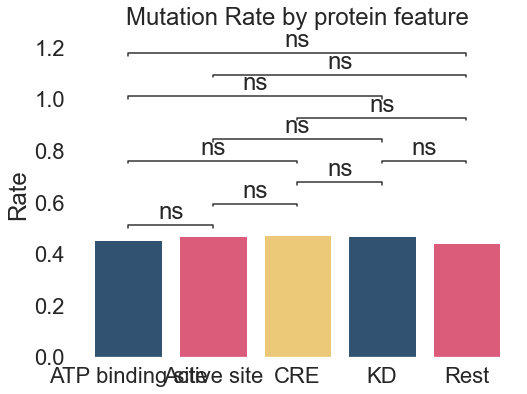

In [74]:
# Apply categorize_term_id function to create a new 'category' column
mutation_rate['category'] = mutation_rate['term_id'].apply(categorize_term_id)

# Group the data by category and calculate the mean rate
grouped = mutation_rate.groupby('category')['rate'].mean()
grouped = grouped.reset_index()

colors = ["#26547c","#ef476f","#ffd166"]

sns.set(rc={'figure.figsize':(8, 6), 'axes.facecolor': 'white'}, font_scale= 2)
# Create the bar plot
#plt.bar(grouped.index, grouped.values, color= colors)
ax = sns.barplot(data= grouped, x= "category", y= "rate", palette= colors)

# Combinations to compare
comb = combinations(grouped.category.unique(), 2)
pairs = [ i for i in comb ]

annotator = Annotator(ax= ax, pairs= pairs, data= grouped, x= "category", y= "rate")
annotator.configure(test= 'Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

plt.xlabel('')
plt.ylabel('Rate')
plt.title('Mutation Rate by protein feature')
plt.show()

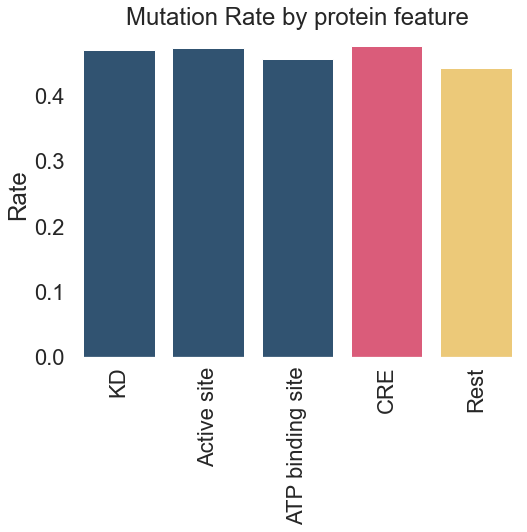

In [78]:
# Apply categorize_term_id function to create a new 'category' column
mutation_rate['category'] = mutation_rate['term_id'].apply(categorize_term_id)

# Group the data by category and calculate the mean rate
grouped = mutation_rate.groupby('category')['rate'].mean()
grouped = grouped.reset_index()

colors = ["#26547c", "#26547c", "#26547c", "#ef476f","#ffd166"]

sns.set(rc={'figure.figsize':(8, 6), 'axes.facecolor': 'white'}, font_scale= 2)
# Create the bar plot
#plt.bar(grouped.index, grouped.values, color= colors)
ax = sns.barplot(data= grouped, x= "category", y= "rate", palette= colors,
                order= ["KD","Active site", "ATP binding site", "CRE", "Rest"])

# # Combinations to compare
# comb = combinations(grouped.category.unique(), 2)
# pairs = [ i for i in comb ]

# annotator = Annotator(ax= ax, pairs= pairs, data= grouped, x= "category", y= "rate")
# annotator.configure(test= 'Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

plt.xlabel('')
plt.xticks(rotation= 90)
plt.ylabel('Rate')
plt.title('Mutation Rate by protein feature')
plt.show()

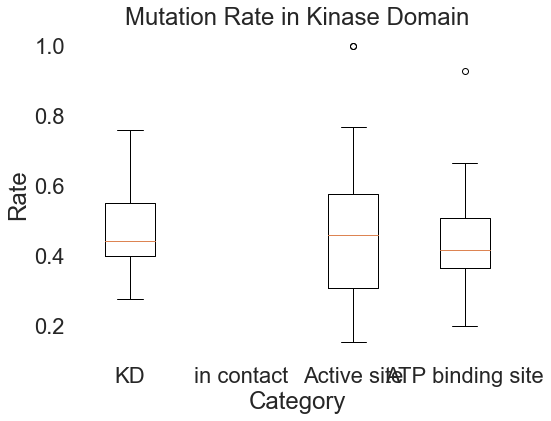

In [79]:
# Create the box plot - KD rates
plt.boxplot([mutation_rate[mutation_rate['category'] == 'KD']['rate'],
            mutation_rate[mutation_rate['category'] == 'in contact']['rate'],
            mutation_rate[mutation_rate['category'] == 'Active site']['rate'],
            mutation_rate[mutation_rate['category'] == 'ATP binding site']['rate']],
            labels=['KD', "in contact", 'Active site', 'ATP binding site'])
plt.xlabel('Category')
plt.ylabel('Rate')
plt.title('Mutation Rate in Kinase Domain')
plt.show()

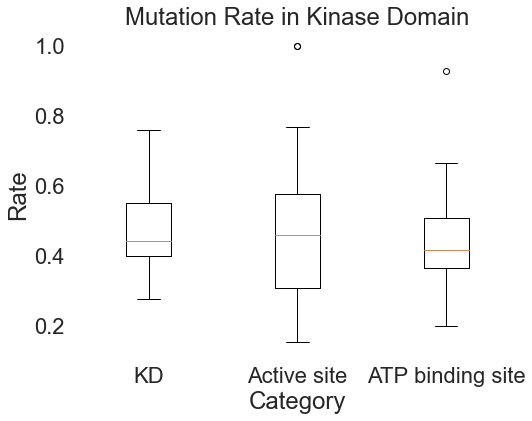

In [80]:
# Create the box plot - KD rates
plt.boxplot([mutation_rate[mutation_rate['category'] == 'KD']['rate'],
            mutation_rate[mutation_rate['category'] == 'Active site']['rate'],
            mutation_rate[mutation_rate['category'] == 'ATP binding site']['rate']],
            labels=['KD', 'Active site', 'ATP binding site'])
plt.xlabel('Category')
plt.ylabel('Rate')
plt.title('Mutation Rate in Kinase Domain')
plt.show()

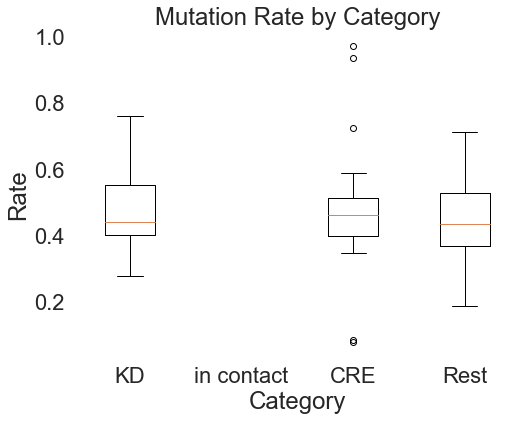

In [81]:
# Create the box plot
plt.boxplot([mutation_rate[mutation_rate['category'] == 'KD']['rate'],
            mutation_rate[mutation_rate['category'] == 'in contact']['rate'],
             mutation_rate[mutation_rate['category'] == 'CRE']['rate'],
             mutation_rate[mutation_rate['category'] == 'Rest']['rate']],
            labels=['KD', "in contact", 'CRE', 'Rest'])
plt.xlabel('Category')
plt.ylabel('Rate')
plt.title('Mutation Rate by Category')
plt.show()

In [63]:
mutation_rate

,uniprot,term_id,mutated_positions,length,rate,category
0,P00519,cre35,1,13,0.076923,CRE
1,P00519,rest27,3,8,0.375000,Rest
2,P00519,rest26,12,46,0.260870,Rest
3,P00519,cre36,55,173,0.317919,CRE
4,P00519,kd37,132,252,0.523810,KD
...,...,...,...,...,...,...
104,Q16620,rest185,118,286,0.412587,Rest
105,Q9Y243,rest232,2,16,0.125000,Rest
106,Q9Y243,cre276,61,131,0.465649,CRE
107,Q9Y243,kd276,99,258,0.383721,KD


In [83]:
mutation_rate

,uniprot,term_id,mutated_positions,length,rate,category
0,P00519,cre35,1,13,0.076923,CRE
1,P00519,active_site,6,13,0.461538,Active site
2,P00519,rest26,14,46,0.304348,Rest
3,P00519,ATP_binding_site,16,24,0.666667,ATP binding site
4,P00519,in_contact,21,1,21.000000,None
...,...,...,...,...,...,...
158,Q9Y243,active_site,5,13,0.384615,Active site
159,Q9Y243,ATP_binding_site,15,34,0.441176,ATP binding site
160,Q9Y243,rest240,25,74,0.337838,Rest
161,Q9Y243,cre276,64,131,0.488550,CRE


In [86]:
mutation_rate["in_contact"] = mutation_rate.term_id == 'in_contact'
mutation_rate

,uniprot,term_id,mutated_positions,length,rate,category,in_contact
0,P00519,cre35,1,13,0.076923,CRE,False
1,P00519,active_site,6,13,0.461538,Active site,False
2,P00519,rest26,14,46,0.304348,Rest,False
3,P00519,ATP_binding_site,16,24,0.666667,ATP binding site,False
4,P00519,in_contact,21,1,21.000000,None,True
...,...,...,...,...,...,...,...
158,Q9Y243,active_site,5,13,0.384615,Active site,False
159,Q9Y243,ATP_binding_site,15,34,0.441176,ATP binding site,False
160,Q9Y243,rest240,25,74,0.337838,Rest,False
161,Q9Y243,cre276,64,131,0.488550,CRE,False


In [95]:
mutation_rate_dummy = mutation_rate.copy()
mutation_rate_dummy['active_site'] = mutation_rate_dummy.term_id == "active_site"
mutation_rate_dummy["atp_binding"] = mutation_rate_dummy.term_id == "ATP_binding_site"
mutation_rate_dummy.category = mutation_rate_dummy.category.replace({"ATP binding site": "KD", None: "KD", "Active site": "KD"})
mutation_rate_dummy.term_id = mutation_rate_dummy.term_id.replace({"in_contact": "kd"})
mutation_rate_dummy

,uniprot,term_id,mutated_positions,length,rate,category,in_contact,active_site,atp_binding
0,P00519,cre35,1,13,0.076923,CRE,False,False,False
1,P00519,active_site,6,13,0.461538,KD,False,True,False
2,P00519,rest26,14,46,0.304348,Rest,False,False,False
3,P00519,ATP_binding_site,16,24,0.666667,KD,False,False,True
4,P00519,kd,21,1,21.000000,KD,True,False,False
...,...,...,...,...,...,...,...,...,...
158,Q9Y243,active_site,5,13,0.384615,KD,False,True,False
159,Q9Y243,ATP_binding_site,15,34,0.441176,KD,False,False,True
160,Q9Y243,rest240,25,74,0.337838,Rest,False,False,False
161,Q9Y243,cre276,64,131,0.488550,CRE,False,False,False


In [94]:
mutation_rate_dummy.duplicated().any()

False

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 58.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CRE vs. KD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.484e-01 U_stat=9.820e+02
KD vs. Rest: Mann-Whitney-Wilcoxon test two-sided, P_val:1.001e-01 U_stat=2.630e+03
CRE vs. Rest: Mann-Whitney-Wilcoxon test two-sided, P_val:4.330e-01 U_stat=7.930e+02


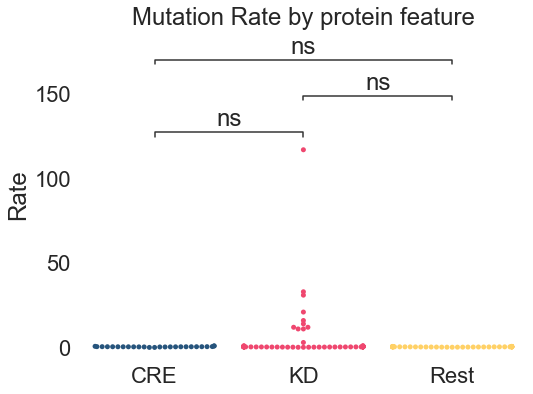

In [101]:
colors = ["#26547c","#ef476f","#ffd166"]

sns.set(rc={'figure.figsize':(8, 6), 'axes.facecolor': 'white'}, font_scale= 2)
# Create the bar plot
#plt.bar(grouped.index, grouped.values, color= colors)
ax = sns.swarmplot(data= mutation_rate_dummy.sort_values("category"), x= "category", y= "rate", palette= colors, hue= "category") # , hue_order= ["CRE", "KD", "rest"]
#sns.boxplot(data= mutation_rate.sort_values("category"), x= "category", y= "rate", palette= colors, hue= "category",  showcaps=False,boxprops={'facecolor':'None'}, showfliers=False)

# Group the data by category and calculate the mean rate
grouped = mutation_rate_dummy.groupby('category')['rate'].mean()
grouped = mutation_rate_dummy.reset_index()
# Combinations to compare
comb = combinations(grouped.category.unique(), 2)
pairs = [ i for i in comb ]

annotator = Annotator(ax= ax, pairs= pairs, data= grouped, x= "category", y= "rate")
annotator.configure(test= 'Mann-Whitney', text_format='star')
annotator.apply_and_annotate()

plt.legend().remove()
plt.xlabel('')
plt.ylabel('Rate')
plt.title('Mutation Rate by protein feature')


plt.show()

In [96]:
mutated_positions

,uniprot,term_id,pos,start,end,length,in_term
31213,P00519,cre35,6,2,14,13,True
17342,P00519,rest26,15,15,60,46,True
22799,P00519,rest26,27,15,60,46,True
27389,P00519,rest26,34,15,60,46,True
19178,P00519,rest26,42,15,60,46,True
...,...,...,...,...,...,...,...
362639,Q9Y243,rest240,466,406,479,74,True
363611,Q9Y243,rest240,469,406,479,74,True
362795,Q9Y243,rest240,472,406,479,74,True
362483,Q9Y243,rest240,474,406,479,74,True


In [97]:
mutated_positions_dummy = mutated_positions.copy()
mutated_positions_dummy["in_contact"] = mutated_positions_dummy.term_id == "in_contact"
mutated_positions_dummy

,uniprot,term_id,pos,start,end,length,in_term,in_contact
31213,P00519,cre35,6,2,14,13,True,False
17342,P00519,rest26,15,15,60,46,True,False
22799,P00519,rest26,27,15,60,46,True,False
27389,P00519,rest26,34,15,60,46,True,False
19178,P00519,rest26,42,15,60,46,True,False
...,...,...,...,...,...,...,...,...
362639,Q9Y243,rest240,466,406,479,74,True,False
363611,Q9Y243,rest240,469,406,479,74,True,False
362795,Q9Y243,rest240,472,406,479,74,True,False
362483,Q9Y243,rest240,474,406,479,74,True,False


### no. of mutations per site

In [51]:
cosmic_uniprot_mut

,transcript_id,uniprot,mutation_id,mutation_aa,mutation_description,pos,start,end,term_id,length,length_protein,in_term
13,ENST00000372348,P00519,113242918,p.Y272H,missense_variant,272,242,493,kd37,252,1130,True
64,ENST00000372348,P00519,113239845,p.T334I,missense_variant,334,242,493,kd37,252,1130,True
115,ENST00000372348,P00519,113256067,p.Q365L,missense_variant,365,242,493,kd37,252,1130,True
146,ENST00000372348,P00519,113256067,p.Q365L,missense_variant,365,359,371,active_site,13,1130,True
203,ENST00000372348,P00519,113256073,p.K635R,missense_variant,635,494,1130,rest29,637,1130,True
...,...,...,...,...,...,...,...,...,...,...,...,...
364061,ENST00000263826,Q9Y243,102404695,p.P466S,missense_variant,466,406,479,rest240,74,479,True
364064,ENST00000263826,Q9Y243,181394871,p.R270H,missense_variant,270,148,405,kd276,258,479,True
364066,ENST00000263826,Q9Y243,181394871,p.R270H,missense_variant,270,267,279,active_site,13,479,True
364073,ENST00000263826,Q9Y243,181391184,p.S472F,missense_variant,472,406,479,rest240,74,479,True


In [53]:
mutated_positions = cosmic_uniprot_mut[['uniprot', 'term_id', 'pos', 'start', 'end', 'length', 'in_term']].drop_duplicates().sort_values(["uniprot", "pos"])
mutated_positions

,uniprot,term_id,pos,start,end,length,in_term
31213,P00519,cre35,6,2,14,13,True
17342,P00519,rest26,15,15,60,46,True
22799,P00519,rest26,27,15,60,46,True
27389,P00519,rest26,34,15,60,46,True
19178,P00519,rest26,42,15,60,46,True
...,...,...,...,...,...,...,...
362639,Q9Y243,rest240,466,406,479,74,True
363611,Q9Y243,rest240,469,406,479,74,True
362795,Q9Y243,rest240,472,406,479,74,True
362483,Q9Y243,rest240,474,406,479,74,True


VER

In [58]:
# Count no. of mutations by feature and them calculate the rate
mutated_positions.groupby(["uniprot", "pos"]).sum().sort_values("in_term")

in_term
uniprot pos         
P00519  6          1
P31751  25         1
        24         1
        22         1
        19         1
...              ...
P45985  110        4
Q02750  80         4
        82         4
P45985  119        4
P36507  83         4

[8941 rows x 1 columns]

In [54]:
# Count no. of mutations by feature and them calculate the rate
cosmic_uniprot_mut.groupby(["uniprot", "pos"]).sum()

mutation_id  in_term
uniprot pos                      
P00519  6      113266026        1
        15     113248686        1
        27     113240760        1
        34     113267067        1
        42     113265008        1
...                  ...      ...
Q9Y243  466    307181081        3
        469    102393802        1
        472    283771937        2
        474    102380790        1
        478    102395961        1

[8941 rows x 2 columns]

In [ ]:
# Count number of mutated positions per each feature
mutation_rate = mutated_positions.groupby(["uniprot", "term_id"])["in_term"].sum().reset_index().sort_values(["uniprot", "in_term"]).rename(columns={'in_term': 'mutated_positions'})
# Add length of each term
mutation_rate = mutation_rate.merge(cosmic_uniprot_mut[["uniprot", "term_id", "length"]].drop_duplicates())
mutation_rate["rate"] = mutation_rate.mutated_positions / mutation_rate.length
mutation_rate.sort_values("rate")